In [1]:
# upgrade tensorflow to the lastest version (2.6.0)
pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages (2.6.0)
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os, glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Add, Conv2D, Input, Lambda
from tensorflow.image import ssim, ResizeMethod
print('Tensoeflow Version ==',tf.__version__)

Tensoeflow Version == 2.6.0


# Create EDSR model and load trained weights

In [5]:
RGB_MEAN = np.array([0.5, 0.5, 0.5]) * 255

def edsr(scale, num_filters=64, num_res_blocks=8, res_block_scaling=None):
    """Creates an EDSR model."""
    x_in = Input(shape=(None, None, 3))
    x = Lambda(normalize)(x_in)

    x = b = Conv2D(num_filters, 3, padding='same')(x)
    for i in range(num_res_blocks):
        b = res_block(b, num_filters, res_block_scaling)
    b = Conv2D(num_filters, 3, padding='same')(b)
    x = Add()([x, b])

    x = upsample(x, scale, num_filters)
    x = Conv2D(3, 3, padding='same')(x)

    x = Lambda(denormalize)(x)
    return Model(x_in, x, name="edsr")

def res_block(x_in, filters, scaling):
    """Creates an EDSR residual block."""
    x = Conv2D(filters, 3, padding='same', activation='relu')(x_in)
    x = Conv2D(filters, 3, padding='same')(x)
    if scaling:
        x = Lambda(lambda t: t * scaling)(x)
    x = Add()([x_in, x])
    return x

def upsample(x, scale, num_filters):
    def upsample_1(x, factor, **kwargs):
        """Sub-pixel convolution."""
        x = Conv2D(num_filters * (factor ** 2), 3, padding='same', **kwargs)(x)
        return Lambda(pixel_shuffle(scale=factor))(x)

    if scale == 2:
        x = upsample_1(x, 2, name='conv2d_1_scale_2')
    elif scale == 3:
        x = upsample_1(x, 3, name='conv2d_1_scale_3')
    elif scale == 4:
        x = upsample_1(x, 2, name='conv2d_1_scale_2')
        x = upsample_1(x, 2, name='conv2d_2_scale_2')
    return x

def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)
 
def normalize(x):
    return (x - RGB_MEAN) / 127.5

def denormalize(x):
    return x * 127.5 + RGB_MEAN

# ========== Metrics ==========
def PSNR(y_true, y_pred):
    max_pixel = 255.0
#     return 10.0 * tf.experimental.numpy.log10((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true))))
    return 10.0 * tf.math.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true))))

def SSIM(y_true, y_pred, max_val=255):
    s = ssim(y_true, y_pred, max_val=max_val)
    return s

# ========== Image Enhancement ==========
def img_hist_modification(arr):
    Max = np.max(arr)
    output = (arr-0)/(Max-0)*255
    return output

In [6]:
weights = './edsr_wts_030_mae.h5'

scale = 4
model = edsr(scale=scale)
model.load_weights(weights)
model.summary()

Model: "edsr"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 6 1792        lambda[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 36928       conv2d[0][0]                     
_______________________________________________________________________________________________

# Create folders for saving output images

In [7]:
# Create folders
edsrFolder = 'HR_EDSR'
subplotFolder = 'Subplots'
HRfolder = 'HR'

try:
    os.mkdir(edsrFolder)
    os.mkdir(subplotFolder)
    os.mkdir(HRfolder)
except:
    pass

# Test for images from the data set

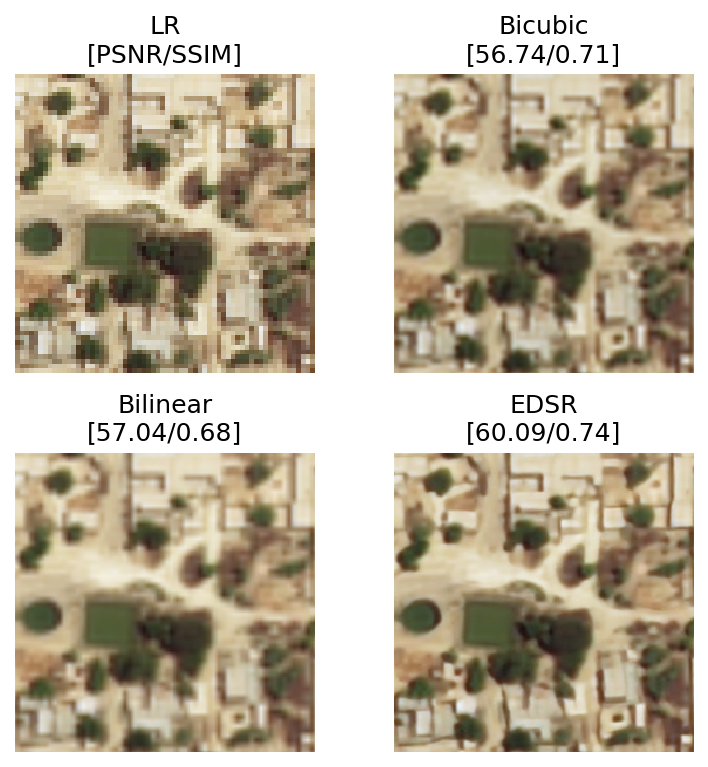

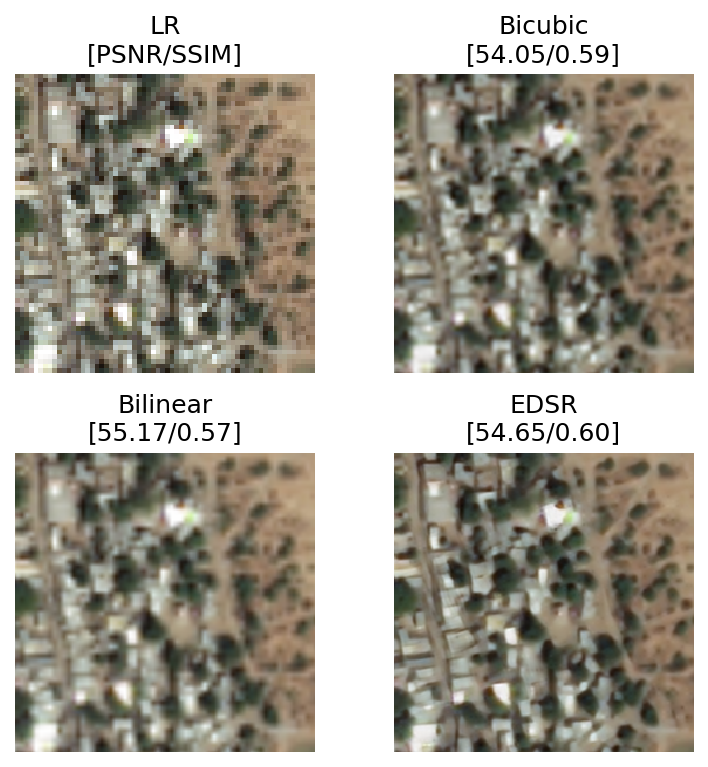

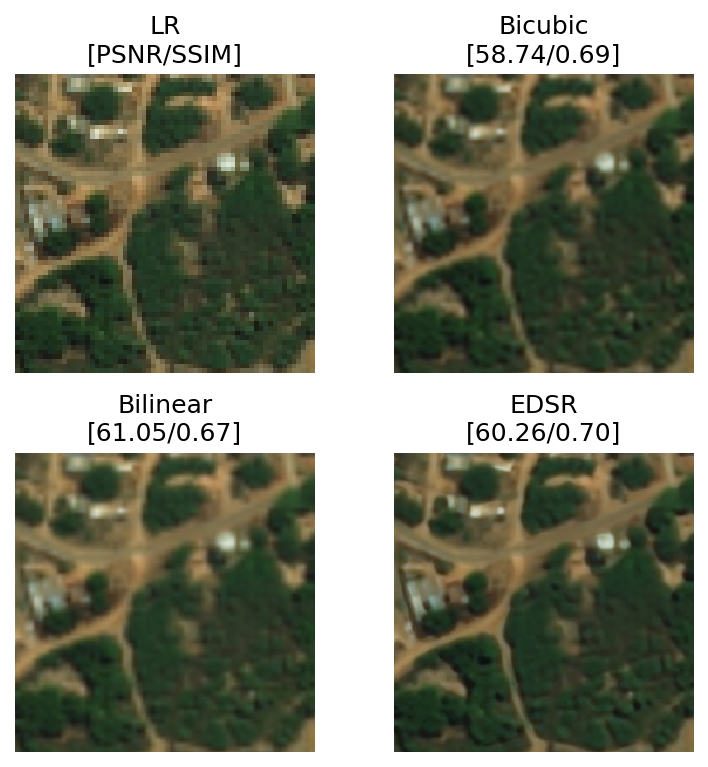

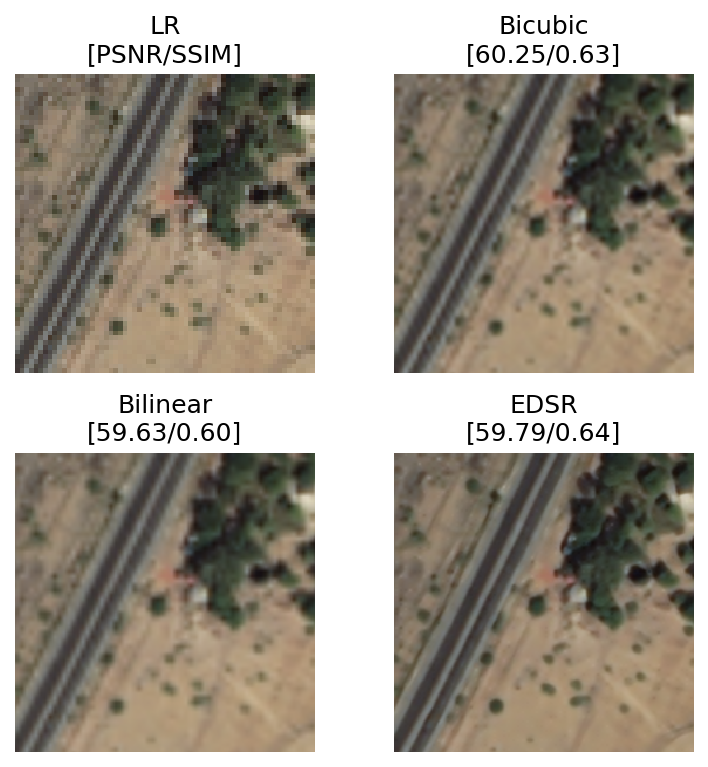

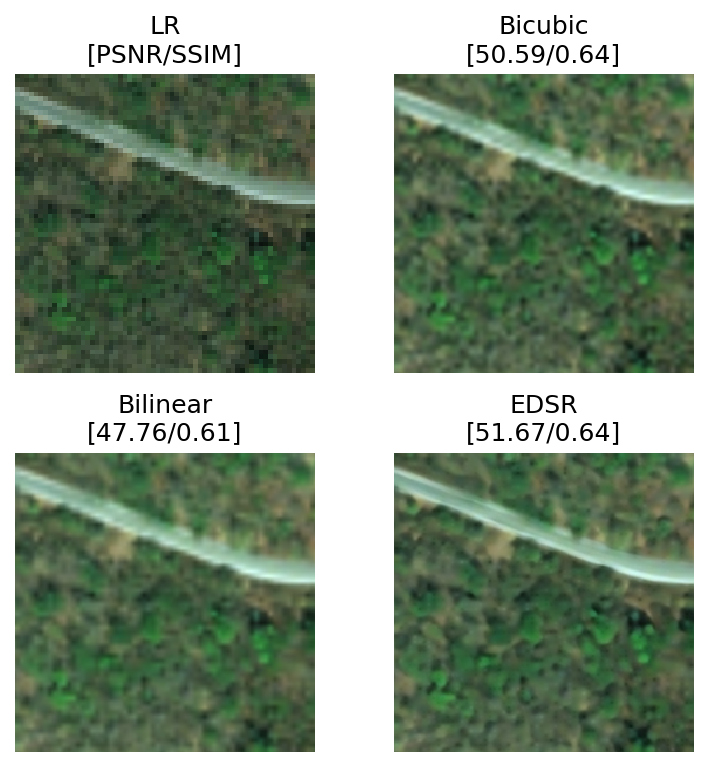

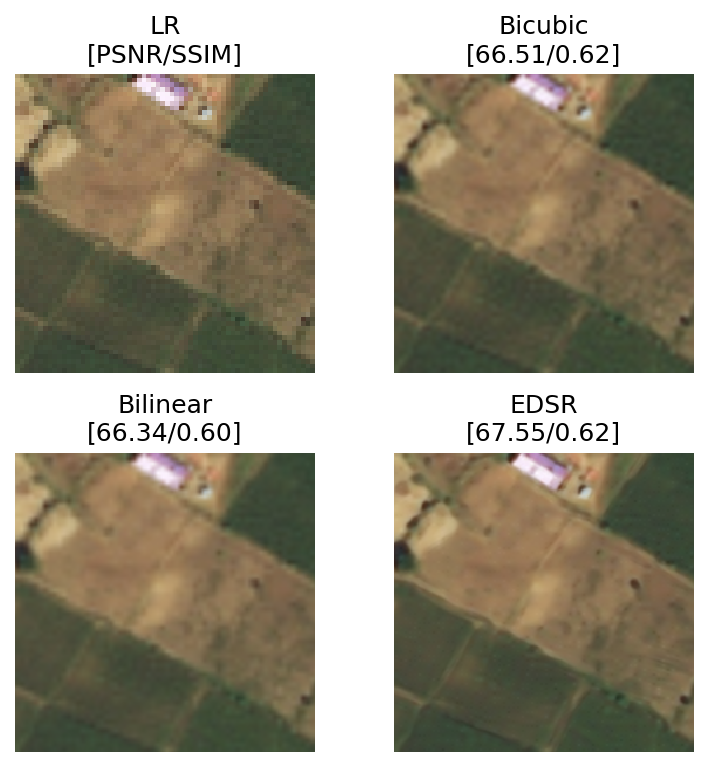

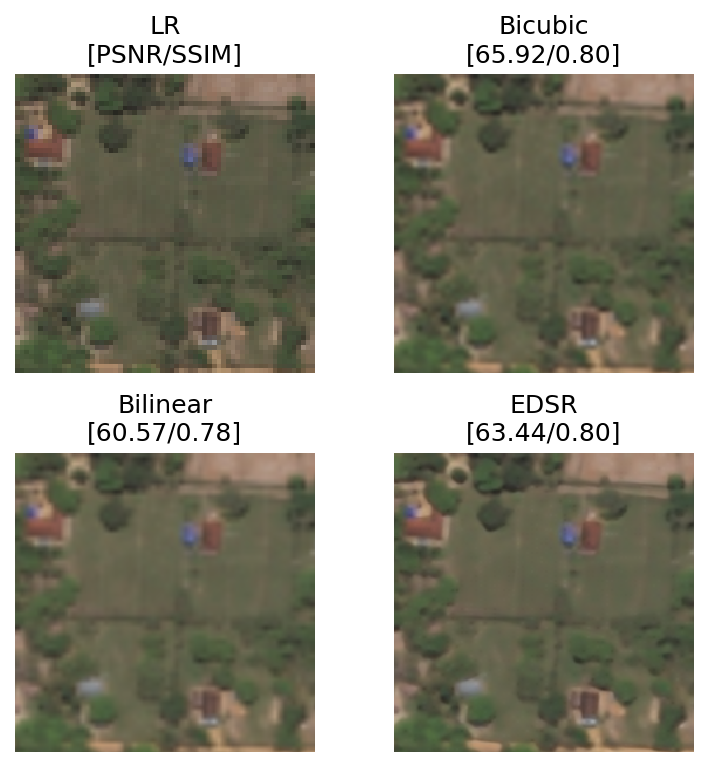

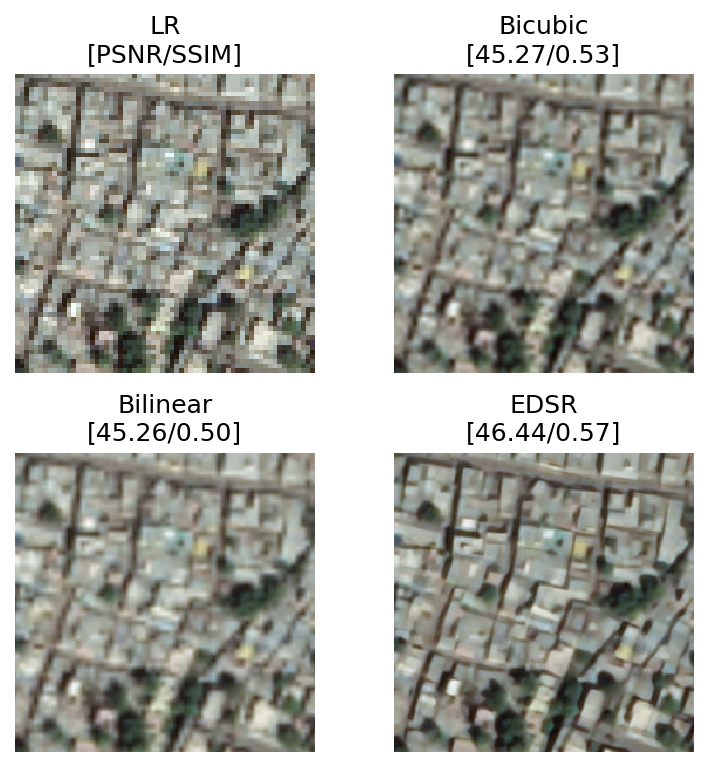

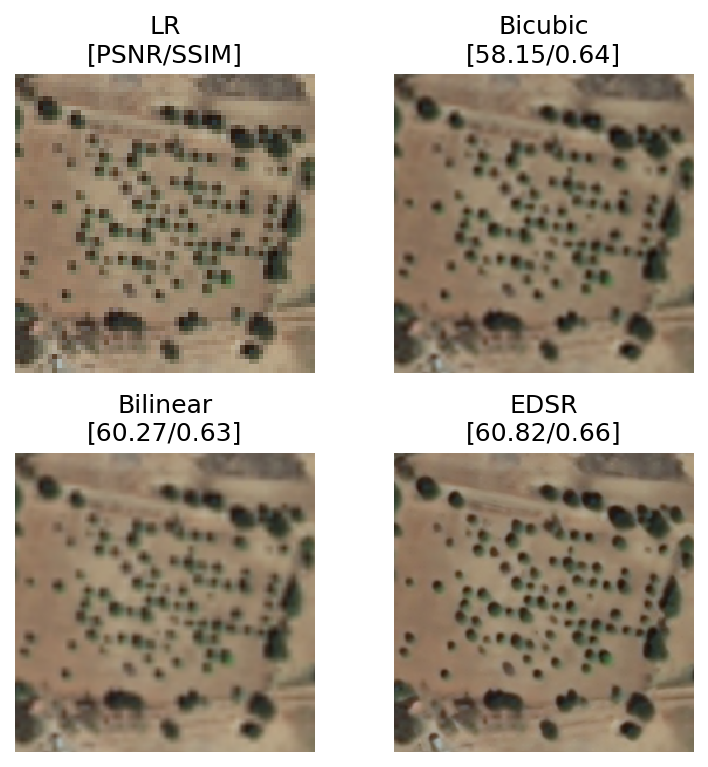

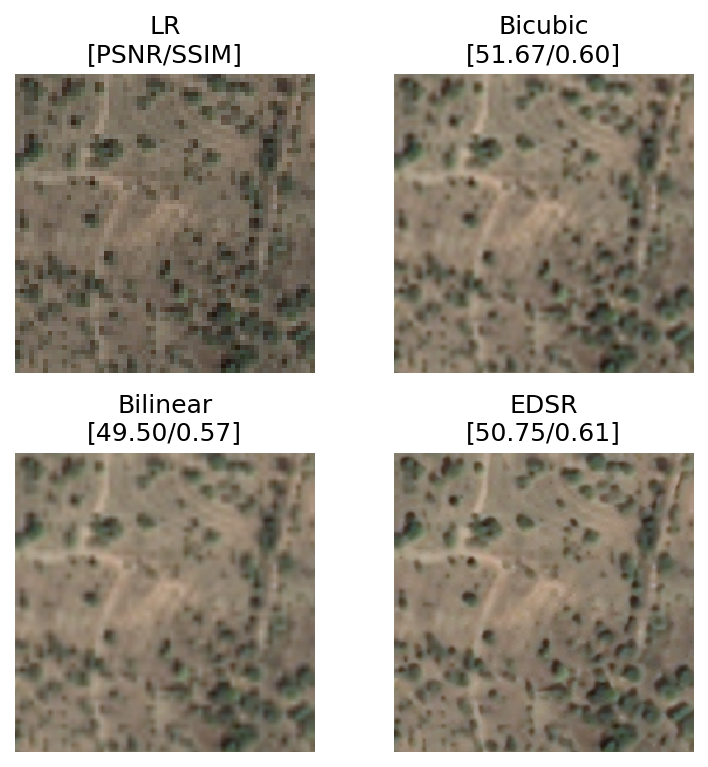

In [11]:
samples = glob.iglob('./Samples/*.jpg')

for img in samples:
    [_,_,name] = img.split('/',2)
    name = name[0:-3]
    
    hr = Image.open(img)
    lr = hr.resize((256,256))
    
    hr = np.array(hr)
    lr = np.array(lr)

    # Change to float32
    hr = tf.cast(hr, tf.float32)
    lr = tf.cast(lr, tf.float32)

    # Expand dimension
    hr = tf.expand_dims(hr, axis=0)
    lr = tf.expand_dims(lr, axis=0)
    
    hr_edsr = model.predict(lr, steps=1)
    hr_cubic = tf.image.resize(lr, [1024,1024], method=ResizeMethod.BICUBIC)
    hr_linear = tf.image.resize(lr, [1024,1024], method=ResizeMethod.BILINEAR)
    
    # Histogram modification
    hr_edsr = img_hist_modification(hr_edsr)
    hr_cubic = img_hist_modification(hr_cubic)
    hr_linear = img_hist_modification(hr_linear)
    
    # Calculate PSNR and SSIM for edsr and Bicubic result
    psnr_edsr = np.float(PSNR(hr, hr_edsr))
    ssim_edsr = np.float(SSIM(hr, hr_edsr))
    psnr_cubic = np.float(PSNR(hr, hr_cubic))
    ssim_cubic = np.float(SSIM(hr, hr_cubic))
    psnr_linear = np.float(PSNR(hr, hr_linear))
    ssim_linear = np.float(SSIM(hr, hr_linear))
    
    # Change data type to Uint8
    lr = tf.cast(lr, tf.uint16)
    hr = tf.cast(hr, tf.uint16)
    hr_edsr = tf.cast(hr_edsr, tf.uint16)
    hr_cubic = tf.cast(hr_cubic, tf.uint16)
    hr_linear = tf.cast(hr_linear, tf.uint16)
    
    # Squeeze the dimension to [width, height, 3]
    lr = tf.squeeze(lr, axis=0)
    hr = tf.squeeze(hr, axis=0)
    hr_edsr = tf.squeeze(hr_edsr, axis=0)
    hr_cubic = tf.squeeze(hr_cubic, axis=0)
    hr_linear = tf.squeeze(hr_linear, axis=0)
    
    plt.imsave(f'./{edsrFolder}/{name}_EDSR.png', np.array(hr_edsr).astype(np.uint8))
    plt.imsave(f'./{HRfolder}/{name}_HR.png', np.array(hr).astype(np.uint8))
    
    fig, ax = plt.subplots(2,2, constrained_layout=True, figsize=(5,5), dpi=150)
    ax[0,0].imshow(lr[64:128,64:128,:], interpolation='nearest')
    ax[0,1].imshow(hr_cubic[256:512,256:512,:], interpolation='nearest')
    ax[1,0].imshow(hr_linear[256:512,256:512,:], interpolation='nearest')
    ax[1,1].imshow(hr_edsr[256:512,256:512,:], interpolation='nearest')
    
    title = ['LR\n[PSNR/SSIM]', 
             f'Bicubic\n[{psnr_cubic:.2f}/{ssim_cubic:.2f}]', 
             f'Bilinear\n[{psnr_linear:.2f}/{ssim_linear:.2f}]', 
             f'EDSR\n[{psnr_edsr:.2f}/{ssim_edsr:.2f}]'
            ]
    
    for x in range(2):
        for y in range(2):
            ax[x,y].set_title(title[2*x+y])
            ax[x,y].axis('off')
    plt.savefig(f'./{subplotFolder}/{name}_subplot.png')

# Test for LandSat-8 Image¶

* Due to the Python environment problem. Please run 'landsat_download.ipynb' before testing the cells below.
* It will download LandSat-8 data automatically for north Taiwan area from USGS by landsatxplore package and extract them.

In [8]:
def img_corr(arr, cut_range=[1000,6000,1500,5000], gamma=0.5):
    """
    To enhance the image data from landsat.
    """
    arr = np.float32(arr)
    crop = arr[cut_range[0]:cut_range[1], cut_range[2]:cut_range[3]]
    Max = np.max(crop)
    Min = np.min(crop)
    
    corr = ((crop-Min)/(Max-Min))**gamma*255
    return corr

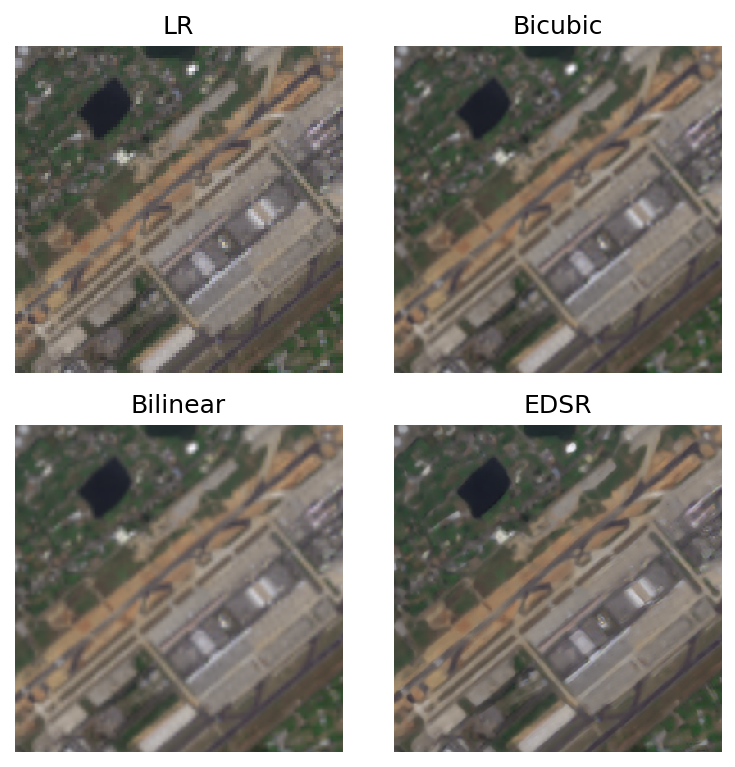

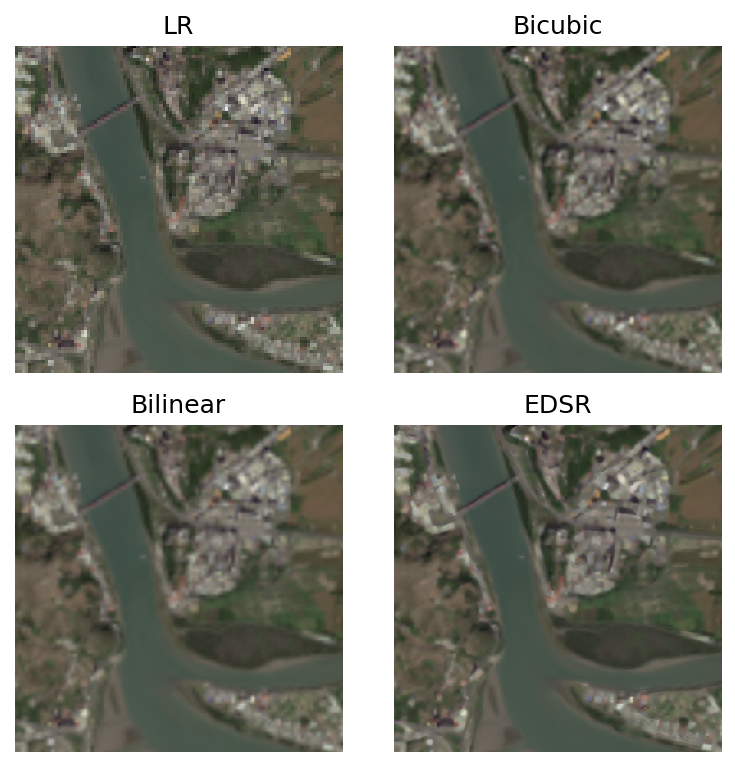

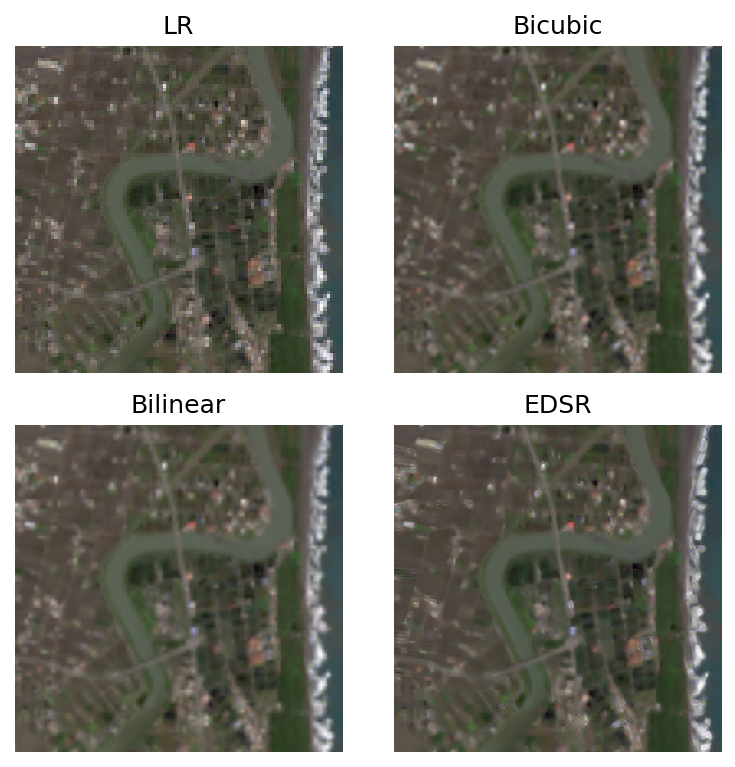

In [10]:
LS_FileName = 'LC08_L1TP_117043_20151116_20170402_01_T1'
  
b2file = './data/' + LS_FileName + '_B2.TIF' # Blue band
b3file = './data/' + LS_FileName + '_B3.TIF' # Green band
b4file = './data/' + LS_FileName + '_B4.TIF' # Red band

b2 = plt.imread(b2file)
b3 = plt.imread(b3file)
b4 = plt.imread(b4file)

b2total = img_corr(b2)
b3total = img_corr(b3)
b4total = img_corr(b4)

# lr_total = np.concatenate((np.expand_dims(b4total,axis=-1), 
#                            np.expand_dims(b3total,axis=-1), 
#                            np.expand_dims(b2total,axis=-1)), axis=2).astype(uint8)

coordinates = [[1875,2025,2387,2537], # Taoyuan Airport
               [1750,1925,3175,3350], # Tamsui River
               [3350,3475,4375,4500]  # Yilan City
              ]
location = ['Taoyuan Airport', 'Tamsui', 'Yilan City']

# plt.imsave(f'./Samples/LS8_HR.png', np.array(lr_total).astype(np.uint8))

for i in range(3):
    cut_range = coordinates[i]
    b2corr = img_corr(b2, cut_range=cut_range) #
    b3corr = img_corr(b3, cut_range=cut_range) #
    b4corr = img_corr(b4, cut_range=cut_range) #

    lr_RGB = np.concatenate((np.expand_dims(b4corr,axis=-1), 
                             np.expand_dims(b3corr,axis=-1), 
                             np.expand_dims(b2corr,axis=-1)), axis=2).astype(int)
    
    # Expand dimension
    lr_RGB_expand_dim = tf.expand_dims(lr_RGB, axis=0)
    shape = lr_RGB_expand_dim.shape
    
    hr_edsr = model.predict(lr_RGB_expand_dim)
    hr_cubic = tf.image.resize(lr_RGB_expand_dim, [shape[1]*4,shape[2]*4], method=ResizeMethod.BICUBIC)
    hr_linear = tf.image.resize(lr_RGB_expand_dim, [shape[1]*4,shape[2]*4], method=ResizeMethod.BILINEAR)
    
    # Histogram modification
    lr_RGB_expand_dim = img_hist_modification(lr_RGB_expand_dim)
    hr_edsr = img_hist_modification(hr_edsr)
    hr_cubic = img_hist_modification(hr_cubic)
    hr_linear = img_hist_modification(hr_linear)

    # Change to uint8 data type
    lr_RGB_expand_dim = tf.cast(lr_RGB_expand_dim, tf.uint8)
    hr_edsr = tf.cast(hr_edsr, tf.uint8)
    hr_cubic = tf.cast(hr_cubic, tf.uint8)
    hr_linear = tf.cast(hr_linear, tf.uint8)
    
    # Squeeze the dimension to [width, height, 3]
    lr = tf.squeeze(lr_RGB_expand_dim, axis=0)
    hr_edsr = tf.squeeze(hr_edsr, axis=0)
    hr_cubic = tf.squeeze(hr_cubic, axis=0)
    hr_linear = tf.squeeze(hr_linear, axis=0)
    
    fig, ax = plt.subplots(2,2, constrained_layout=True, figsize=(5,5), dpi=150)
    ax[0,0].imshow(lr[10:110,10:110,:], interpolation='nearest')
    ax[0,1].imshow(hr_cubic[40:440,40:440,:], interpolation='nearest')
    ax[1,0].imshow(hr_linear[40:440,40:440,:], interpolation='nearest')
    ax[1,1].imshow(hr_edsr[40:440,40:440,:], interpolation='nearest')

    title = ['LR','Bicubic','Bilinear','EDSR']
    
    for x in range(2):
        for y in range(2):
            ax[x,y].set_title(title[2*x+y])
            ax[x,y].axis('off')
            
    plt.savefig(f'./{subplotFolder}/{location[i]}_subplot.png')